In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.10.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.10.2 on the current Colab Runtime...
2024-04-11 19:47:55 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.2-linux-x86_64.tar.gz [169654402/169654402] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.10

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.10.2
Commit bd47eca2c8 (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 6 × AMD Ryzen 5 4500U with Radeon Graphics         
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, znver2)
Threads: 1 default, 0 interactive, 1 GC (on 6 virtual cores)
Environment:
  JULIA_NUM_THREADS = 


In [2]:
import Pkg
Pkg.add("SDDP")
Pkg.add("HiGHS")
Pkg.add("Plots")

    Updating registry at `C:\Users\matsz\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`


In [146]:
using SDDP, HiGHS, Statistics, DataFrames, Plots

In [4]:
expm1.([-0.134, 0.06, 0.254])

3-element Vector{Float64}:
 -0.12540993539666598
  0.06183654654535962
  0.2891718042678043

In [76]:
function asset_management_simple()

    

    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],                                             
            ],
        ),
        lower_bound = -1_800.0,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock = [0.866, 1.06, 1.254]
        r_bonds = [1.05]
        consumption = 5
        goal = 50

        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)

        
        if stage == 1
            @constraint(subproblem, stocks.out + bonds.out + consumption == 55)
            @stageobjective(subproblem, 0)
        elseif 1 < stage < 6
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in +
                r_bonds[1] * bonds.in == stocks.out + bonds.out + consumption
            )
            @stageobjective(subproblem, 0)
        else
            @variable(subproblem, over >= 0)
            @variable(subproblem, short >= 0)
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in +
                r_bonds[1] * bonds.in - over + short + consumption == goal
            )
            @stageobjective(subproblem, -over + 4 * short)
        end
    end
    SDDP.train(model;log_frequency = 5)
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_simple()

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 16
  state variables : 2
  scenarios       : 2.43000e+02
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [5, 7]
  AffExpr in MOI.EqualTo{Float64}         : [1, 1]
  VariableRef in MOI.GreaterThan{Float64} : [3, 5]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e+00, 4e+00]
  bounds range     [2e+03, 2e+03]
  rhs range        [5e+00, 5e+01]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
----------------------------------------------

A policy graph with 16 nodes.
 Node indices: (1, 1), ..., (6, 3)


In [18]:
function asset_management_merton_deterministic()
    
    #goal = 65
    #-(consumption^-1-1)/-1

    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],                                
            ],
        ),
        lower_bound = -200.0,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock_deterministic = [1, 1.06, 0.866, 1.254,1.06,1.06]
        r_bonds = [1.03]
        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)
       # @variable(subproblem, consumption >= 0)

        minimum_limit = 0
        acceptable_limit = 20
        desired_limit = 25

        @variable(subproblem, 0 <= acceptable <= acceptable_limit)
        @variable(subproblem, 0 <= desired <= desired_limit - acceptable_limit)
        @variable(subproblem, 0 <= above_desired)
       # @constraint(subproblem, acceptable + desired + above_desired == consumption)

        if stage == 1
            @constraint(subproblem, stocks.out + bonds.out + acceptable + desired + above_desired == 100)            
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
        elseif 1 < stage #< 6
            @constraint(
                subproblem,
                r_stock_deterministic[stage] * stocks.in + r_bonds[1] * bonds.in == stocks.out + bonds.out + acceptable + desired + above_desired
            )            
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
      #=   else
            @constraint(
                subproblem,
                r_stock_deterministic[stage] * stocks.in + r_bonds[1] * bonds.in == stocks.out + bonds.out + acceptable + desired + above_desired
            )            
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired)) =#
        end 
    end
    SDDP.train(model; log_frequency = 5)
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_merton_deterministic()

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 16
  state variables : 2
  scenarios       : 2.43000e+02
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [8, 8]
  AffExpr in MOI.EqualTo{Float64}         : [1, 1]
  VariableRef in MOI.GreaterThan{Float64} : [6, 6]
  VariableRef in MOI.LessThan{Float64}    : [2, 3]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e+00, 3e+00]
  bounds range     [5e+00, 2e+02]
  rhs range        [1e+02, 1e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
----------------------------------------------

A policy graph with 16 nodes.
 Node indices: (1, 1), ..., (6, 3)


In [18]:
function asset_management_merton()

    
    #goal = 65
    #-(consumption^-1-1)/-1

    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28], 
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
            ]            
        ),
        lower_bound = -370.0,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock = [0.866, 1.06, 1.254]
        r_bonds = [1.04]
        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)


        #@variable(subproblem, consumption >= 0)

        minimum_limit = 0
        acceptable_limit = 15
        desired_limit = 18

        minimum = 5
  
        @variable(subproblem, minimum_limit <= acceptable <= acceptable_limit)
        @variable(subproblem, 0 <= desired <= desired_limit - acceptable_limit)
        @variable(subproblem, 0 <= above_desired)
        @variable(subproblem, consumption >=0)
        @constraint(subproblem, acceptable + desired + above_desired == consumption)
       

        #@constraint(subproblem, acceptable + desired + above_desired == consumption)
        
        if stage == 1
            @constraint(subproblem, stocks.out + bonds.out + consumption == 100)            
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
        elseif 1 < stage 
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in + r_bonds[1] * bonds.in == stocks.out + bonds.out + consumption)
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired ))
        end
    end
    SDDP.train(model; iteration_limit =1000, log_frequency = 100)
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_merton()

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 25
  state variables : 2
  scenarios       : 6.56100e+03
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [9, 9]
  AffExpr in MOI.EqualTo{Float64}         : [2, 2]
  VariableRef in MOI.GreaterThan{Float64} : [7, 7]
  VariableRef in MOI.LessThan{Float64}    : [2, 3]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e+00, 3e+00]
  bounds range     [3e+00, 4e+02]
  rhs range        [1e+02, 1e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
----------------------------------------------

A policy graph with 25 nodes.
 Node indices: (1, 1), ..., (9, 3)


In [123]:
function asset_management_alm()

    
    #goal = 65
    #-(consumption^-1-1)/-1

    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28], 
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
            ]            
        ),
        lower_bound = -370.0,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock = [0.866, 1.06, 1.254]
        r_bonds = [1.04]
        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)

        @variable(subproblem, bonds_buy >= 0)
        @variable(subproblem, bonds_sell >= 0)
        @variable(subproblem, stocks_buy >= 0)
        @variable(subproblem, stocks_sell >= 0)

        #@variable(subproblem, consumption >= 0)

        minimum_limit = 0
        acceptable_limit = 13
        desired_limit = 17

        inflows = [0 3 3 3 3 0 0 0 0]
          
        @variable(subproblem, minimum_limit <= acceptable <= acceptable_limit)
        @variable(subproblem, 0 <= desired <= desired_limit - acceptable_limit)
        @variable(subproblem, 0 <= above_desired)
        @variable(subproblem, consumption >=0)
        @constraint(subproblem, acceptable + desired + above_desired == consumption)
       
              
        if stage == 1
            @constraint(subproblem, bonds_buy - bonds_sell == bonds.out)
            @constraint(subproblem, stocks_buy - stocks_sell == stocks.out)
            @constraint(subproblem, stocks_buy + bonds_buy + consumption == 130) 
                   
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
        elseif 1 < stage 
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in + stocks_buy - stocks_sell== stocks.out)

            @constraint(
                subproblem,
                r_bonds[1] * bonds.in + bonds_buy - bonds_sell== bonds.out)

            @constraint(subproblem, stocks_buy - stocks_sell + bonds_buy - bonds_sell + consumption - inflows[stage] == 0) 

            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired ))
        end
    end
    SDDP.train(model; iteration_limit =1000, log_frequency = 100)
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_alm()

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 25
  state variables : 2
  scenarios       : 6.56100e+03
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [13, 13]
  AffExpr in MOI.EqualTo{Float64}         : [4, 4]
  VariableRef in MOI.GreaterThan{Float64} : [11, 11]
  VariableRef in MOI.LessThan{Float64}    : [2, 3]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e+00, 3e+00]
  bounds range     [4e+00, 4e+02]
  rhs range        [3e+00, 1e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
------------------------------------------

A policy graph with 25 nodes.
 Node indices: (1, 1), ..., (9, 3)


In [124]:
SDDP.calculate_bound(model)

-432.0315912956523

In [93]:
SDDP.numerical_stability_report(model)

numerical stability report
  matrix range     [9e-01, 4e+00]
  objective range  [1e+00, 3e+00]
  bounds range     [2e+01, 2e+03]
  rhs range        [6e+00, 2e+02]


In [125]:
rule = SDDP.DecisionRule(model; node = (1,1))

A decision rule for node (1, 1)

In [126]:
solution = SDDP.evaluate(
    rule;
    incoming_state = Dict(:stocks => 30.0),
    noise = 50.0,
    #controls_to_record = [:hydro_generation, :thermal_generation],
)

(stage_objective = -62.03159129565226, outgoing_state = Dict(:bonds => 4.179100503264624, :stocks => 93.78930820108312), controls = Dict{Any, Any}())

In [127]:
simulations = SDDP.simulate(
    # The trained model to simulate.
    model,
    # The number of replications.
    1000,
    # A list of names to record the values of.
    [:stocks, :bonds, :acceptable, :desired, :above_desired, :consumption],
    skip_undefined_variables=true
)

replication = 23
stage =4
simulations[replication][stage]

Dict{Symbol, Any} with 12 entries:
  :bonds           => State{Float64}(17.4228, 22.8932)
  :bellman_term    => -230.83
  :node_index      => (4, 3)
  :objective_state => nothing
  :belief          => Dict((4, 3)=>1.0)
  :stage_objective => -47.0
  :acceptable      => 13.0
  :consumption     => 17.0
  :above_desired   => 0.0
  :noise_term      => nothing
  :stocks          => State{Float64}(52.5194, 47.0858)
  :desired         => 4.0

In [128]:
plt = SDDP.SpaghettiPlot(simulations)

SDDP.add_spaghetti(plt; title = "Stocks") do data
    return data[:stocks].out
end

SDDP.plot(plt)


In [104]:
plt = SDDP.SpaghettiPlot(simulations)

SDDP.add_spaghetti(plt; title = "Consumption") do data
    return data[:acceptable] + data[:desired] + data[:above_desired]
end

SDDP.plot(plt)

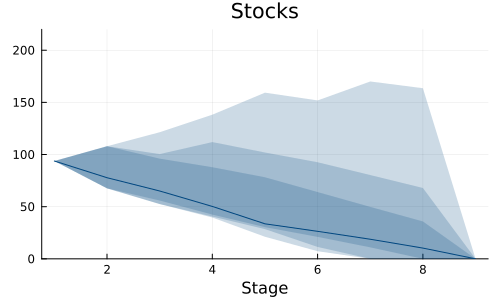

In [129]:
import Plots

Plots.plot(
    SDDP.publication_plot(simulations, title = "Stocks") do data
        return data[:stocks].out
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 220),
    layout = (1, 2),
)

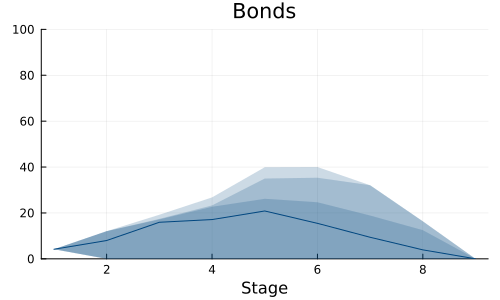

In [130]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Bonds") do data
        return data[:bonds].out
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 100),
    layout = (1, 2),
)

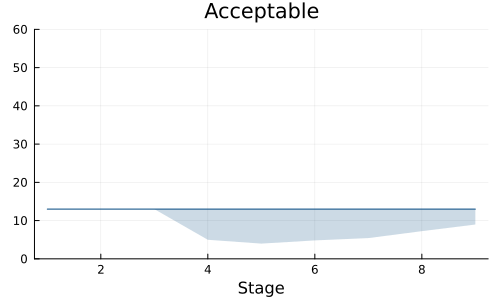

In [131]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Acceptable") do data
        return data[:acceptable]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 60),
    layout = (1, 2),
)

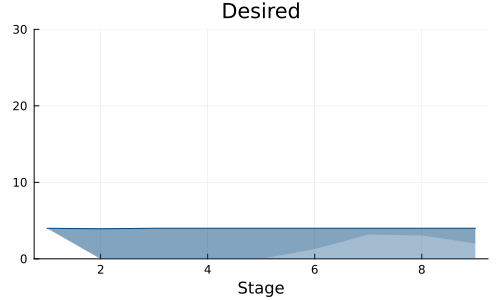

In [132]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Desired") do data
        return data[:desired]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 30),
    layout = (1, 2),
)

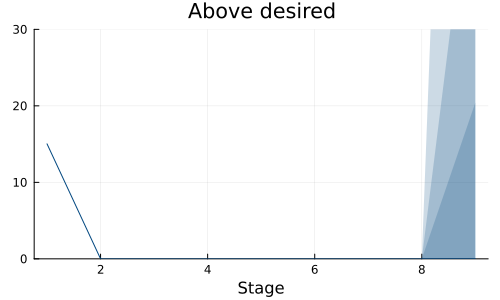

In [134]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Above desired") do data
        return data[:above_desired]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 30),
    layout = (1, 2),
)

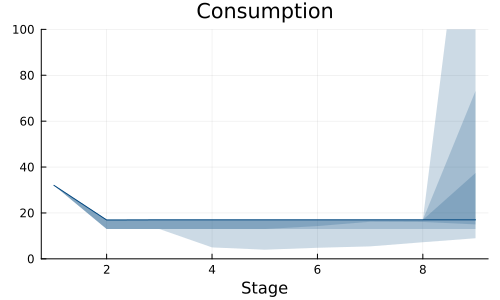

In [135]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Consumption") do data
        return data[:consumption]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 100),
    layout = (1, 2),
)

In [136]:
n_scenarios = 1000
n_stages = 9

bonds = zeros(n_scenarios,n_stages)
stocks = zeros(1000,n_stages)
consumption = zeros(1000,n_stages)

for (i, scenario) in enumerate(simulations)
    bonds[i,:] = [node[:bonds].out for node in scenario]
    stocks[i,:] = [node[:stocks].out for node in scenario]
    consumption[i,:] = [node[:acceptable] + node[:desired] + node[:above_desired] for node in scenario]
end

bonds_perc = zeros(5,n_stages)

for t in 1:n_stages
    bonds_perc[:,t] = quantile(bonds[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

bonds_perc

5×9 Matrix{Float64}:
 4.1791   0.0       0.0      0.0     …   0.0      0.0       0.0      0.0
 4.1791   0.0       0.0      0.0         0.0      0.0       0.0      0.0
 4.1791   7.98701  15.936   17.1218     15.4723   9.39649   3.91554  0.0
 4.1791  12.0591   17.1777  22.7004     24.6561  18.8789   12.5      0.0
 4.1791  12.0591   19.2207  25.7172     37.6017  32.0636   16.3462   0.0

In [137]:
stocks_perc = zeros(5,n_stages)

for t in 1:n_stages
    stocks_perc[:,t] = quantile(stocks[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

stocks_perc 

5×9 Matrix{Float64}:
 93.7893   67.5808   52.5194   39.789   …   -4.04948e-11  -4.85407e-11  0.0
 93.7893   67.5808   55.8892   42.4175      10.9957        3.47873e-9   0.0
 93.7893   77.7752   65.0471   50.2413      18.7989       10.3093       0.0
 93.7893  107.958    96.0715   87.8358      49.8039       35.8588       0.0
 93.7893  107.958   121.379   114.662      100.804        87.4615       0.0

In [138]:
wealth = stocks .+ bonds

wealth_perc = zeros(5,n_stages)

for t in 1:n_stages
    wealth_perc[:,t] = quantile(wealth[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

DataFrame(wealth_perc, :auto)

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,97.9684,75.5678,56.8315,50.2413,43.2558,30.3094,21.7104,10.3668,0.0
2,97.9684,75.5678,69.9421,63.7518,55.0707,42.8485,28.8173,14.2248,0.0
3,97.9684,89.8342,80.9831,70.0459,59.9003,46.9535,32.0636,16.3462,0.0
4,97.9684,107.958,96.0715,87.8358,78.2062,64.0347,49.8039,35.8588,0.0
5,97.9684,107.958,121.379,114.662,119.518,110.841,100.804,87.4615,0.0


In [139]:
stocks_weight = stocks ./wealth

stocks_weight[:,end] .= 0

stocks_weight

1000×9 Matrix{Float64}:
 0.957342  0.894307  1.0       1.0       …   1.0          1.94404e-13  0.0
 0.957342  0.865763  0.759179  0.667568      0.547471     0.724739     0.0
 0.957342  0.894307  0.756862  0.629498      0.546717     0.724739     0.0
 0.957342  0.894307  0.756862  0.853183      1.0          1.0          0.0
 0.957342  1.0       1.0       1.0           1.0          1.0          0.0
 0.957342  1.0       1.0       1.0       …   1.0          1.0          0.0
 0.957342  1.0       1.0       1.0           1.0          1.0          0.0
 0.957342  0.894307  1.0       1.0           0.388962     0.724739     0.0
 0.957342  0.865763  0.759179  0.667568      0.82265      1.90392e-13  0.0
 0.957342  0.894307  0.756862  0.853183      1.0          1.0          0.0
 ⋮                                       ⋱                             
 0.957342  0.865763  0.759179  0.643925      0.724739     2.48042e-10  0.0
 0.957342  1.0       1.0       1.0           1.0          1.0          0.0
 0.9

In [140]:
stocks_weight = stocks ./wealth

stocks_weight[:,end] .= 0

stocks_weight_perc = zeros(5,n_stages)

for t in 1:n_stages
    stocks_weight_perc[:,t] = quantile(stocks_weight[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

DataFrame(stocks_weight_perc, :auto)

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.957342,0.865763,0.750898,0.629498,0.375274,0.213376,-1.26295e-12,-3.2518e-12,0.0
2,0.957342,0.865763,0.759179,0.644205,0.528652,0.490886,0.391927,2.25457e-10,0.0
3,0.957342,0.894307,0.803218,0.765381,0.637663,0.61292,0.674291,0.724739,0.0
4,0.957342,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0.957342,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


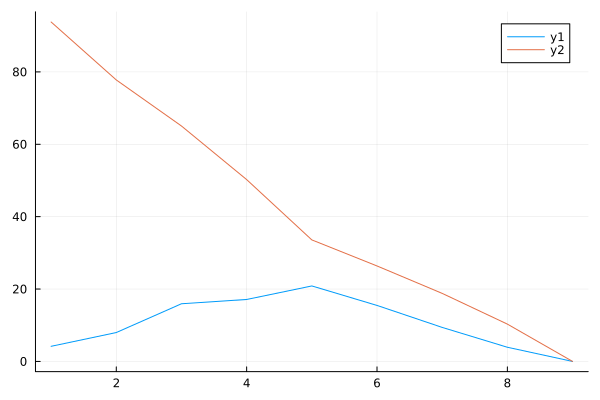

In [152]:
plot(1:9,bonds_perc[3,:])
plot!(1:9,stocks_perc[3,:])

In [142]:
consumption_perc = zeros(5,n_stages)

for t in 1:n_stages
    consumption_perc[:,t] = quantile(consumption[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

DataFrame(consumption_perc, :auto) 

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,32.0316,13.0,13.0,13.0,13.0,13.0,13.0,12.6462,13.0
2,32.0316,13.0,13.0,13.0,13.0,14.2772,16.1658,16.0607,15.0
3,32.0316,16.9287,17.0,17.0,17.0,17.0,17.0,17.0,17.0
4,32.0316,17.0,17.0,17.0,17.0,17.0,17.0,17.0,37.4381
5,32.0316,17.0,17.0,17.0,17.0,17.0,17.0,17.0,94.0622


In [143]:
acceptable_limit = 13
desired_limit = 18
limits = [acceptable_limit, desired_limit]

goals_succes = zeros(n_stages,2)

for goal in 1:2
    goals_succes[:,goal] = [count(c -> (c >= limits[goal]), consumption[:,t]) /n_scenarios for t in 1:n_stages]
end

DataFrame(goals_succes, ["13","18"])

Row,13,18
,Float64,Float64
1,1.0,1.0
2,1.0,0.0
3,1.0,0.0
4,0.98,0.0
5,0.96,0.0
6,0.956,0.0
7,0.962,0.0
8,0.943,0.0
9,0.909,0.409


In [144]:
[quantile(sum(consumption,dims=2),[0.05, 0.25, 0.5, 0.75, 0.95])]

1-element Vector{Vector{Float64}}:
 [131.58126338807304, 151.33655206382812, 164.0315912956529, 188.15207022647388, 245.0929298686136]

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />